# Feature matching - PUBLIC VERSION

This notebook explores feature matching algorithm using SIFT and specific data preprocessing.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import skimage
from skimage import data, color, transform
from skimage.color import rgb2gray
from skimage.filters import meijering, sato, frangi, hessian
from skimage.feature import (match_descriptors, corner_harris,
                             corner_peaks, ORB, plot_matches,
                             hessian_matrix, hessian_matrix_eigvals,
                             hog, SIFT)
from skimage.transform import ProjectiveTransform, SimilarityTransform, warp
from skimage.measure import ransac
from skimage.io import imread, imshow, imsave

import cv2
import helpers

%load_ext autoreload
%autoreload 2

# Load the data

Note: this code is used on the private dataset. For illustrating the notebook, we will use another couple of image that come from a public dataset.

In [ ]:
DATA_DIR = "/data/ml4s2021/data/2021_11_12/OphtalmoLaus/"
OUTPUT_DIR = "./output/"

images_df = helpers.load_df(DATA_DIR)

grouped_df = images_df.groupby(['patient_id', 'eye', 'centrage'], as_index=False)

target_df = grouped_df.first()
target_df[target_df['patient_id'] == '1']

df = pd.merge(
    target_df,
    images_df,
    how='inner',
    on=['patient_id', 'eye', 'centrage'],
    suffixes=('_target', '_source')
)
df = df[df['num_target'] != df['num_source']]
print(df.shape)
df[df['patient_id'] == '1']

# Registration

## Loading and preprocessing image

For preprocessing, we do the following:

- convert to gray img
- apply sato
- remove background
- remove circle
- normalize / augment contrast

Note: on the next plots, the left image will be the target and the right image will be the source/moving.

Text(0.5, 1.0, 'source')

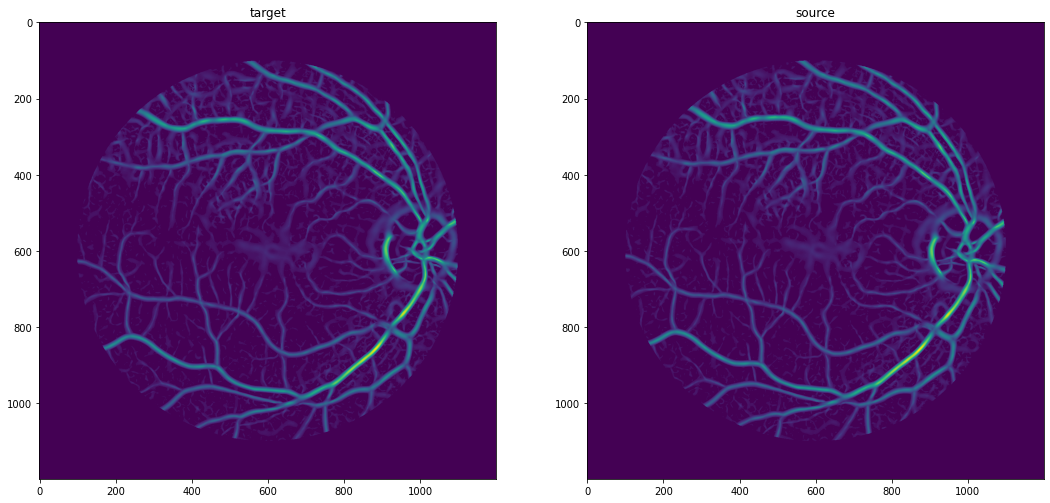

In [10]:
# paths = df.iloc[130][['path_target', 'path_source']]
paths = ['./public_data/public_target.jpg', './public_data/public_source.jpg']
target, source = map(
    lambda x: helpers.imp(x, resize=False, vessels=True, exposure=True, cv=True),
    paths
)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,12))

axs[0].imshow(target)
axs[0].set_title("target")

axs[1].imshow(source)
axs[1].set_title("source")

## Feature detection and descriptor extraction

Next, we use SIFT for feature detection and descriptor extraction. We choose sigma=5 and edgeThreshold after many tries, and it helps to detect features along the vessels.

Text(0.5, 1.0, 'source')

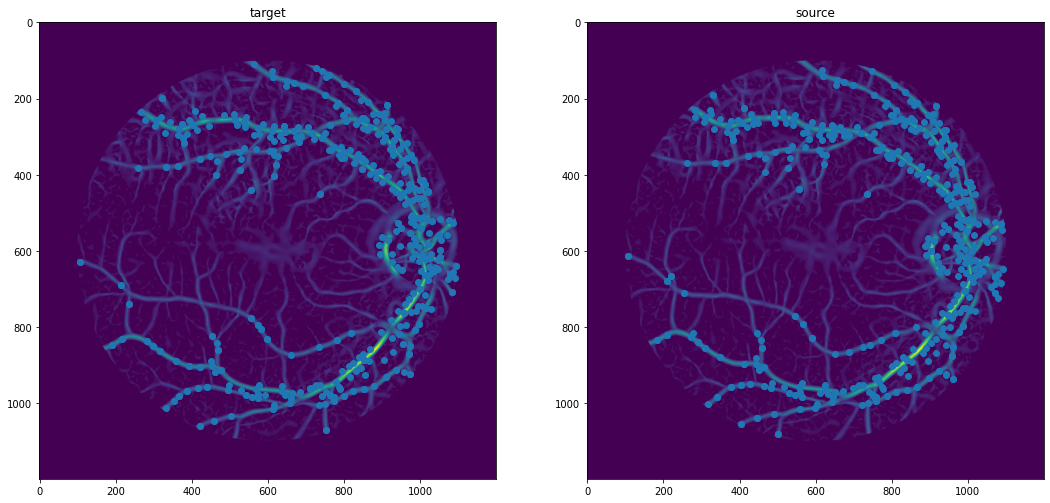

In [11]:
sift = cv2.SIFT_create(
    sigma=5,
    nfeatures=500,
    edgeThreshold=50,
)

target_keypoints, target_descriptors = sift.detectAndCompute(target, None)
source_keypoints, source_descriptors = sift.detectAndCompute(source, None)

target_keypoints_arr = cv2.KeyPoint.convert(target_keypoints)
target_keypoints_arr[:, 0], target_keypoints_arr[:, 1] = target_keypoints_arr[:, 1], target_keypoints_arr[:, 0].copy()
source_keypoints_arr = cv2.KeyPoint.convert(source_keypoints)
source_keypoints_arr[:, 0], source_keypoints_arr[:, 1] = source_keypoints_arr[:, 1], source_keypoints_arr[:, 0].copy()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,12))

axs[0].imshow(target)
axs[0].scatter(target_keypoints_arr[:,1], target_keypoints_arr[:,0])
axs[0].set_title("target")

axs[1].imshow(source)
axs[1].scatter(source_keypoints_arr[:,1], source_keypoints_arr[:,0])
axs[1].set_title("source")

## Descriptors matching

We match the descriptors by brute-forcing. After comparing the different metrics, we found out that the correlation distance gives the best results.

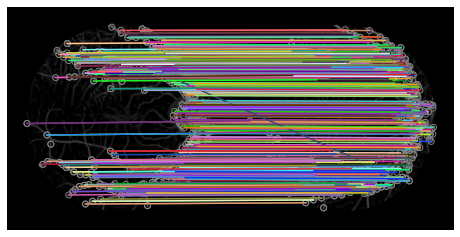

In [12]:
matches = match_descriptors(
    target_descriptors,
    source_descriptors,
    cross_check=True,
    metric='correlation'
)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plot_matches(
    ax,
    target,
    source,
    target_keypoints_arr,
    source_keypoints_arr,
    matches,
    keypoints_color='grey',
)
plt.axis('off')
plt.show()

## Outlier rejection

We reject outliers using RANSAC.

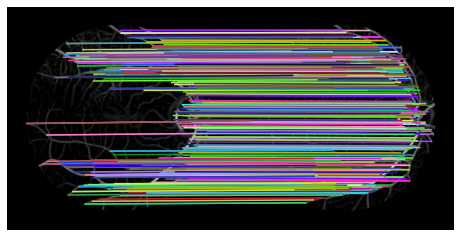

In [13]:
src = source_keypoints_arr[matches[:, 1]][:, ::-1]
tgt = target_keypoints_arr[matches[:, 0]][:, ::-1]

model_robust, inliers = ransac((src, tgt), skimage.transform.SimilarityTransform, # SimilarityTransform,
                              min_samples=10, residual_threshold=70,
                              max_trials=500)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plot_matches(ax, target, source, target_keypoints_arr, source_keypoints_arr, matches[inliers], only_matches=True)
plt.axis('off')
plt.show()

## Warping

Warping is done using the model we got from RANSAC. We first apply it to our gray images.

Lossy conversion from float64 to uint8. Range [-1.0, 254.640907719871]. Convert image to uint8 prior to saving to suppress this warning.


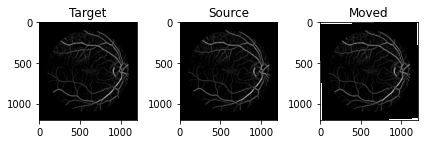

In [15]:
moved = warp(
    source,
    model_robust.inverse,
    preserve_range=True,
    output_shape=target.shape,
    cval=-1,
)
moved = np.ma.array(moved, mask=moved==-1)

fig, ax = plt.subplots(1, 3)

ax[0].imshow(target, cmap=plt.get_cmap('gray'))
ax[0].set_title("Target")
ax[1].imshow(source, cmap=plt.get_cmap('gray'))
ax[1].set_title("Source")
ax[2].imshow(moved, cmap=plt.get_cmap('gray'))
ax[2].set_title("Moved")

imsave(OUTPUT_DIR+"public_fm_moving.jpg", source)
imsave(OUTPUT_DIR+"public_fm_atarget.jpg", target)
imsave(OUTPUT_DIR+"public_fm_moved.jpg", moved)

plt.tight_layout()
plt.show()

We can finally use the same transformation on the full images.

Lossy conversion from float64 to uint8. Range [-1.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


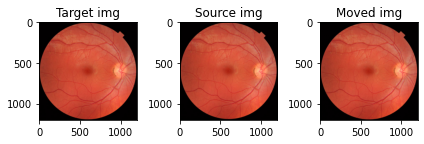

In [17]:
target_img, source_img = imread(paths[0]), imread(paths[1])

moved_img = warp(source_img, model_robust.inverse, preserve_range=True, output_shape=target.shape, cval=-1)
moved_img = np.ma.array(moved_img, mask=moved_img==-1)

fig, ax = plt.subplots(1, 3)

ax[0].imshow(target_img)
ax[0].set_title("Target img")
ax[1].imshow(source_img)
ax[1].set_title("Source img")
ax[2].imshow(moved_img/255)
ax[2].set_title("Moved img")

imsave(OUTPUT_DIR+"public_ifm_moving.jpg", source_img)
imsave(OUTPUT_DIR+"public_ifm_atarget.jpg", target_img)
imsave(OUTPUT_DIR+"public_ifm_moved.jpg", moved_img)

plt.tight_layout()
plt.show()

For easier comparaison, the three images can be found in the output folder.

# Result

The most suitable metric for our result should be mutual information, but we also print out other ones.

In [27]:
print("Mutual information")
print(f"Target - Source : {skimage.metrics.normalized_mutual_information(target, source):.3f}")
print(f"Target - Moved  : {skimage.metrics.normalized_mutual_information(target, moved):.3f}")

print('\n-- Other metrics --')

print("\nMean squared error")
print(f"Target - Source : {skimage.metrics.mean_squared_error(target, source):.3f}")
print(f"Target - Moved  : {skimage.metrics.mean_squared_error(target, moved):.3f}")

print("\nStructural similarity")
print(f"Target - Source : {skimage.metrics.structural_similarity(target, source):.3f}")
print(f"Target - Moved  : {skimage.metrics.structural_similarity(target, moved):.3f}")

Mutual information
Target - Source : 1.089
Target - Moved  : 1.456

-- Other metrics --

Mean squared error
Target - Source : 368.428
Target - Moved  : 11.630

Structural similarity
Target - Source : 0.679
Target - Moved  : 0.964
